## Download Required Models
Download the required models from the internet if they don't already exist locally. They will be downloaded into the following folders:
```
|- dataset
  |- aclImbd
    |- test
    |- train
|- models
  |- glove.6B.50d.txt
  |- glove.6B.100d.txt
  |- glove.6B.200d.txt
  |- glove.6B.300d.txt
```

In [37]:
import os
import urllib.request
import zipfile
import tarfile

def download_and_extract_if_not_exist(url, extract_path, zip_file_name, zip_file_contents_file_name):

    # If any of the files already exist, skip the download - it's already been done and extracted
    path = os.path.join(extract_path, zip_file_contents_file_name)
    if os.path.exists(path):
        print("Files already exist. Skipping download.")
        return

    # Check if the zip file already exists, if it does, skip the download to save time
    zip_file_path = os.path.join(extract_path, zip_file_name)
    if not os.path.exists(zip_file_path):
        print("Downloading zip file...")
        if not os.path.exists(extract_path):
            os.makedirs(extract_path)
        # Download the zip file
        zip_file_path, _ = urllib.request.urlretrieve(url, zip_file_path)
    else:
        print("Zip file already exists. Skipping download.")

    # Extract the contents of the zip file to the given directory based on the file extension
    if zip_file_path.endswith(".zip"):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    elif zip_file_path.endswith(".tar.gz") or zip_file_path.endswith(".tgz"):
        with tarfile.open(zip_file_path, 'r:gz') as tar_ref:
            tar_ref.extractall(extract_path)

    # Close and remove the zip file to free up space
    os.remove(zip_file_path)
    print(f"Files extracted to: {extract_path}")


In [38]:
# Download the word embeddings into the following folder:
folder_to_download = "./models"

# 6 Billion token model
embedding_url = "https://nlp.stanford.edu/data/glove.6B.zip"
file_name_to_download = "glove.6B.zip"

# Download and extract the embedding file, then set a variable with the path to the embedding file
download_and_extract_if_not_exist(embedding_url, folder_to_download, file_name_to_download, "glove.6B.50d.txt")
word_embedding_file_path = os.path.join(folder_to_download, "glove.6B.300d.txt")

Files already exist. Skipping download.


In [39]:
# Download the dataset into the following folder:
folder_to_download = "./dataset"

# 6 Billion token model
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
file_name_to_download = "aclImdb_v1.tar.gz"

# Download and extract, then set the path to the dataset
download_and_extract_if_not_exist(dataset_url, folder_to_download, file_name_to_download, "aclImdb/imdb.vocab")
dataset_folder= os.path.join(folder_to_download, "aclImdb")

Files already exist. Skipping download.


## Load the Data
From the downloaded dataset, load the data into memory, trim the excessively long reviews

In [40]:
# Read the imdb reviews from the dataset folder
dataset_folder= os.path.join(folder_to_download, "aclImdb")
def read_imdb_data_from_folder(imdb_reviews_folder):
    texts = []
    labels = []
    review_folders = ["pos", "neg"] # there are 2 folders in each dataset folder: pos and neg
    for connotation_dir in review_folders:
        review_dir = os.path.join(imdb_reviews_folder, connotation_dir)
        for filename in os.listdir(review_dir):
            with open(os.path.join(review_dir, filename), "r", encoding="utf8") as f:
                texts.append(f.read())
            labels.append(0 if connotation_dir == "neg" else 1)
    return texts, labels

def get_negative_positive_from_label(label):
    return "negative" if label == 0 else "positive"

In [41]:
# Load the IMDB Movie Review dataset from the downloaded folder
test_texts, test_labels = read_imdb_data_from_folder(os.path.join(dataset_folder, "test"))
train_texts, train_labels = read_imdb_data_from_folder(os.path.join(dataset_folder, "train"))

In [42]:
# Tokenize and pad review sequences
import torchtext
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
train_texts_tokenized = [tokenizer(review) for review in train_texts]
test_texts_tokenized = [tokenizer(review) for review in test_texts]

In [43]:
# Calculate the average length of the training text and test text 
total_length = 0
count = 0

for nested_array in test_texts_tokenized:
    total_length += len(nested_array)
    count += 1

# Calculate the average length
average_length = total_length / count
print(f"Torch test: {average_length}")

for nested_array in train_texts_tokenized:
    total_length += len(nested_array)
    count += 1

# Calculate the average length
average_length = total_length / count
print(f"Torch training: {average_length}")

Torch test: 264.63664
Torch training: 267.66206


### Hyperparameters for Training

In [45]:
# Hyperparameters and imports

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

state_dimensions = [20, 50, 100, 200, 500]
embedding_dim = 300  # Adjust this to match the embedding dimension of the word embeddings you are using
max_len = 500  # Adjust this to trim the maximum length of review that is allowed into the model
num_epochs = 15
learning_rate = 0.001

In [46]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# If the texts are longer than 500 words, shorten them, so they have a max of 500 words.
def truncate_nested_arrays(array, max_length):
    new_array = [None] * len(array)
    for i in range(len(array)):
        new_array[i] = array[i][:max_length]
    return new_array

cuda


In [47]:

train_texts_tokenized = truncate_nested_arrays(train_texts_tokenized, max_len)
test_texts_tokenized = truncate_nested_arrays(test_texts_tokenized, max_len)


In [48]:
# Build the vocabulary, convert each token into a number that maps to the real word in the vocabulary (based on appearance)
vocab = torchtext.vocab.build_vocab_from_iterator(train_texts_tokenized + test_texts_tokenized)

train_sequences = [torch.tensor([vocab[token] for token in review], dtype=torch.long, device=device)for review in train_texts_tokenized]
test_sequences = [torch.tensor([vocab[token]for token in review], dtype=torch.long, device=device) for review in test_texts_tokenized]

train_padded = nn.utils.rnn.pad_sequence(train_sequences, batch_first=True, padding_value=0).float()
test_padded = nn.utils.rnn.pad_sequence(test_sequences, batch_first=True, padding_value=0).float()

In [49]:
print(vocab["i"])
print(vocab["found"])
print(train_texts_tokenized[0])
print(len(train_padded[4]))
print(len(test_padded[5]))

11
255
['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', '.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life', ',', 'such', 'as', 'teachers', '.', 'my', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', 'high', "'", 's', 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', 'teachers', '.', 'the', 'scramble', 'to', 'survive', 'financially', ',', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', 'teachers', "'", 'pomp', ',', 'the', 'pettiness', 'of', 'the', 'whole', 'situation', ',', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students', '.', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school', ',', 'i', 'immediately', 'recalled', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'at', '.', '.', '.', '.', '.', '.', '

## Load the Pre-Trained Embeddings
Load the pre-trained embedding model into memory. To minimize the lookup time during training, create an embedding matrix that only contains the embeddings for words already in the vocabulary.

In [50]:
# Download GloVe word embeddings - currently using dimension 50
glove_file = word_embedding_file_path
embedding_index = {}
with open(glove_file, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [51]:
# Create embedding matrix, then convert it to a tensor
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in vocab.get_stoi().items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix_tensor = torch.tensor(embedding_matrix, device=device)

## LSTM and RNN Text Classifier Classes
Classes for the LSTM and RNN text classifier models that will be used for training

In [52]:
# Build model classifier logics and forward pass
class LSTMTextClassifier(nn.Module):
    def __init__(self, embedding_dim, state_dim):
        super(LSTMTextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_tensor, freeze=True)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=state_dim, batch_first=True, device=device)
        self.fc = nn.Linear(state_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        x = x.float()
        output, _ = self.lstm(x)
        max_pooling_output, _ = torch.max(output, 1)
        output = self.fc(max_pooling_output)
        output = self.sigmoid(output)
        return output


print_things = False

# Build model
class RNNTextClassifier(nn.Module):
    def __init__(self, embedding_dim, state_dim):
        super(RNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_tensor, freeze=True)
        self.rnn = nn.RNN(embedding_dim, state_dim, batch_first=True, device=device)
        self.fc = nn.Linear(state_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Args:
            x: Input tensor containing a sequence of tokens
        Return: The output of the current RNN, a list out tensors (a list of binary classifications)
        """
        x = x.long()
        vector_embedding = self.embedding(x).float()
        rnn_output, _ = self.rnn(vector_embedding)
        # Option 1: Pooling (e.g., max pooling)
        max_pooling_output, _ = torch.max(rnn_output, 1)
        output = self.fc(max_pooling_output)
        output = self.sigmoid(output)
        if print_things: print(f"Model output: {output}")
        return output

def model_training_loop(model, criterion, optimizer, training_data_loader):

    loss = None
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch in training_data_loader:
            inputs, labels = batch[0], batch[1]
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluation_loop(model, test_loader) -> float:
    # Evaluation
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy


In [53]:
batch_size_training = 64
batch_size_testing = 64

# Model training loop
results_rnn = []

train_label_tensor = torch.tensor(train_labels, dtype=torch.float32, device=device)
test_label_tensor = torch.tensor(test_labels, dtype=torch.float32, device=device)

# Convert to tensor dataset
train_dataset = TensorDataset(train_padded, train_label_tensor)
test_dataset = TensorDataset(test_padded, test_label_tensor)

# Converty the tensor datasets into a dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_testing, shuffle=True)

for state_dim in state_dimensions:
    model = RNNTextClassifier(embedding_dim, state_dim).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss() # Different criterion commonly used for classification tasks
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model_training_loop(model, criterion, optimizer, train_loader)
    accuracy = evaluation_loop(model, test_loader)
    results_rnn.append(("RNN", state_dim, accuracy))

# Display results
print("Results:")
print("| Model | State Dimension | Accuracy | Max Words |")
print("|-------|-----------------|----------| --------- |")
for result in results_rnn:
    print(f"| {result[0]} | {result[1]} | {result[2]:.4f}% | {max_len}")

Results:
| Model | State Dimension | Accuracy | Max Words |
|-------|-----------------|----------| --------- |
| RNN | 20 | 86.7240% | 500
| RNN | 50 | 87.9000% | 500
| RNN | 100 | 88.3040% | 500
| RNN | 200 | 87.7640% | 500
| RNN | 500 | 88.4920% | 500


## LSTM Hyperparameter Evaluation

In [54]:
results_lstm = []

for state_dim in state_dimensions:

    model = LSTMTextClassifier(embedding_dim, state_dim).to(device)
    # Loss and optimizer
    criterion = nn.BCELoss() # Different criterion commonly used for classification tasks
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model_training_loop(model, criterion, optimizer, train_loader)
    accuracy = evaluation_loop(model, test_loader)
    results_lstm.append(("LSTM", state_dim, accuracy))

# Display results
print("Results:")
print("| Model | State Dimension | Accuracy | Max Words |")
print("|-------|-----------------|----------| --------- |")
for result in results_lstm:
    print(f"| {result[0]} | {result[1]} | {result[2]:.4f}% | {max_len}")

Results:
| Model | State Dimension | Accuracy | Max Words |
|-------|-----------------|----------| --------- |
| LSTM | 20 | 88.8320% | 500
| LSTM | 50 | 89.2920% | 500
| LSTM | 100 | 89.8120% | 500
| LSTM | 200 | 89.5120% | 500
| LSTM | 500 | 90.2960% | 500


### Graph the Current Test Run
Graph the test run that has just completed, comparing the RNN and LSTM

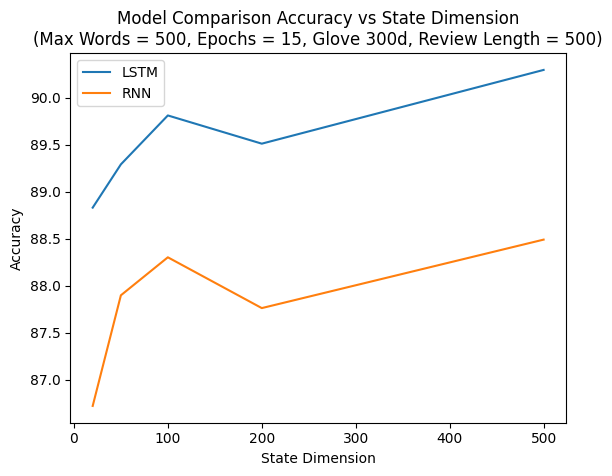

In [59]:
import matplotlib.pyplot as plt

# Extract the state dimensions and accuracies from the results
state_dimensions_lstm = [result[1] for result in results_lstm]
accuracies_lstm = [result[2] for result in results_lstm]

state_dimensions_rnn = [result[1] for result in results_rnn]
accuracies_rnn = [result[2] for result in results_rnn]

# Plot the results
plt.plot(state_dimensions_lstm, accuracies_lstm, label='LSTM')
plt.plot(state_dimensions_rnn, accuracies_rnn, label='RNN')

# Add labels and title to the plot
plt.xlabel('State Dimension')
plt.ylabel('Accuracy')
plt.title('Model Comparison Accuracy vs State Dimension\n(Max Words = 500, Epochs = 15, Glove 300d, Review Length = 500)')
plt.legend()

# Show the plot
plt.show()


### Plot the recorded test runs manually
There were 16+ test runs trialed for each model, so eaching track of them in memory became quite difficult. Instead the results were recorded and then will be read in below to generate the graphs for the report.

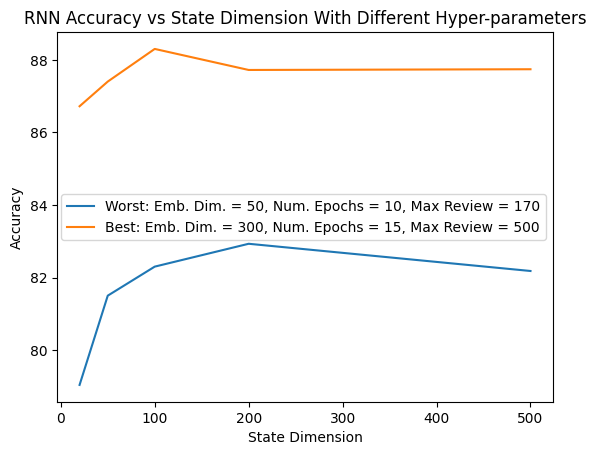

In [72]:
# Graph the Best and Worse Average Accuracy runs for RNN - considerring the average accuracy for all state dimensions
dimensions = [20, 50, 100, 200, 500]
rrn_worst_accuracy = [79.04, 81.50, 82.30, 82.93, 82.18]
rrn_best_accuracy = [86.72, 87.40, 88.30, 87.72, 87.74]

# Plot the results
plt.plot(dimensions, rrn_worst_accuracy, label='Worst: Emb. Dim. = 50, Num. Epochs = 10, Max Review = 170')
plt.plot(dimensions, rrn_best_accuracy, label='Best: Emb. Dim. = 300, Num. Epochs = 15, Max Review = 500')

# Add labels and title to the plot
plt.xlabel('State Dimension')
plt.ylabel('Accuracy')
plt.title('RNN Accuracy vs State Dimension With Different Hyper-parameters')
plt.legend()

# Show the plot
plt.show()


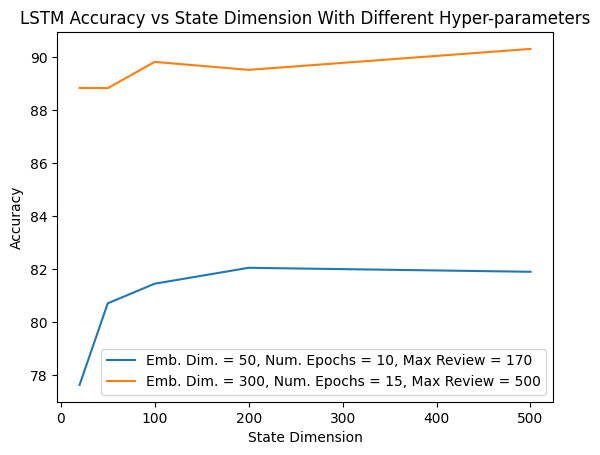

In [73]:
# Graph the Best and Worse Average Accuracy runs for LSTM - considerring the average accuracy for all state dimensions
# Graph the Best and Worse Average Accuracy runs for RNN - considerring the average accuracy for all state dimensions
lstm_worst_accuracy = [77.62, 80.70, 81.44, 82.04, 81.89]
lstm_best_accuracy = [88.83, 88.82, 89.81, 89.51, 90.30]

# Plot the results
plt.plot(dimensions, lstm_worst_accuracy, label='Emb. Dim. = 50, Num. Epochs = 10, Max Review = 170')
plt.plot(dimensions, lstm_best_accuracy, label='Emb. Dim. = 300, Num. Epochs = 15, Max Review = 500')

# Add labels and title to the plot
plt.xlabel('State Dimension')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy vs State Dimension With Different Hyper-parameters')
plt.legend()

# Show the plot
plt.show()

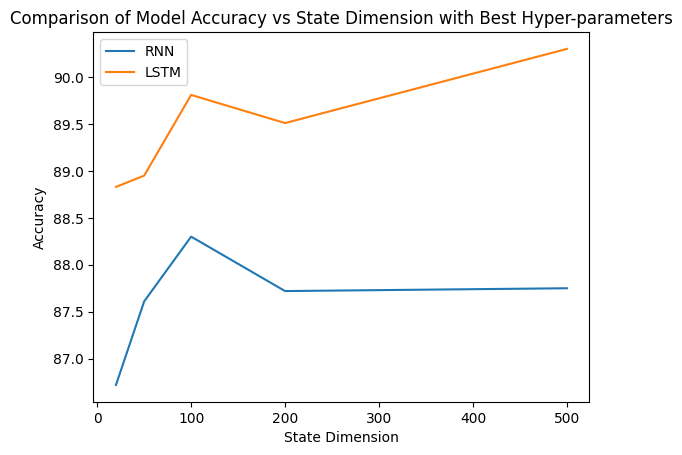

In [74]:
# Graph the Best Accuracy for RNN and LSTM - for each dimenion
# Graph the Best and Worse Average Accuracy runs for LSTM - considerring the average accuracy for all state dimensions
# Graph the Best and Worse Average Accuracy runs for RNN - considerring the average accuracy for all state dimensions
rnn_best_accuracy_total = [86.72, 87.61, 88.30, 87.72, 87.75]
lstm_best_accuracy_total = [88.83, 88.95, 89.81, 89.51, 90.30]

# Plot the results
plt.plot(dimensions, rnn_best_accuracy_total, label='RNN')
plt.plot(dimensions, lstm_best_accuracy_total, label='LSTM')

# Add labels and title to the plot
plt.xlabel('State Dimension')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy vs State Dimension with Best Hyper-parameters')
plt.legend()

# Show the plot
plt.show()